<a href="https://colab.research.google.com/github/sanjay7178/pytorch-dip/blob/main/PyTorch_Blurring_Deblurring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://2.img-dpreview.com/files/p/TS250x250~sample_galleries/7595010911/6327297101.jpg -o 300.jpg


In [ ]:
!pip install pillow


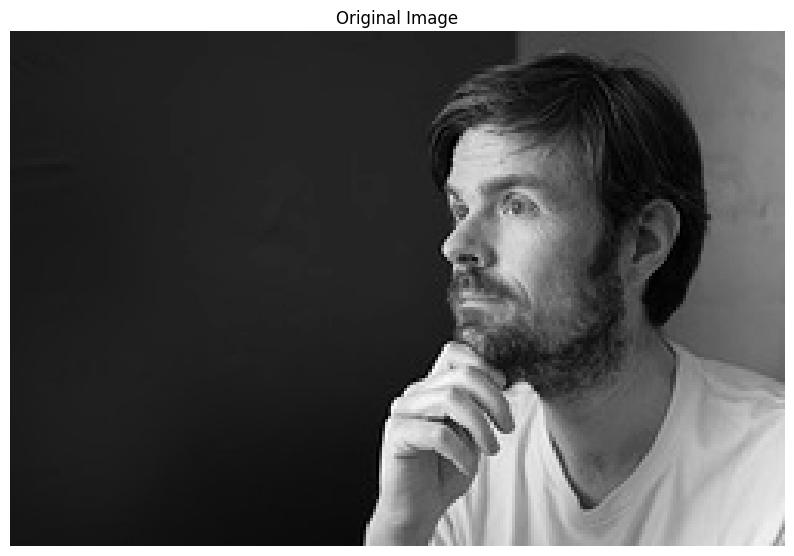

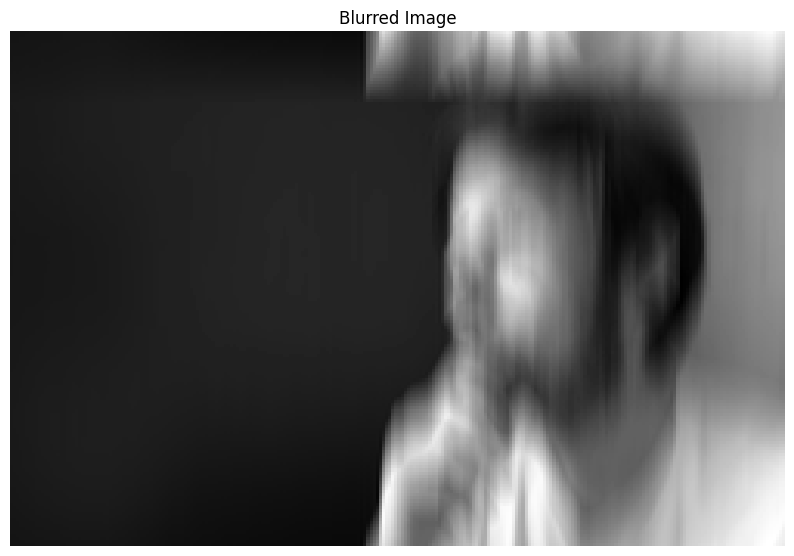

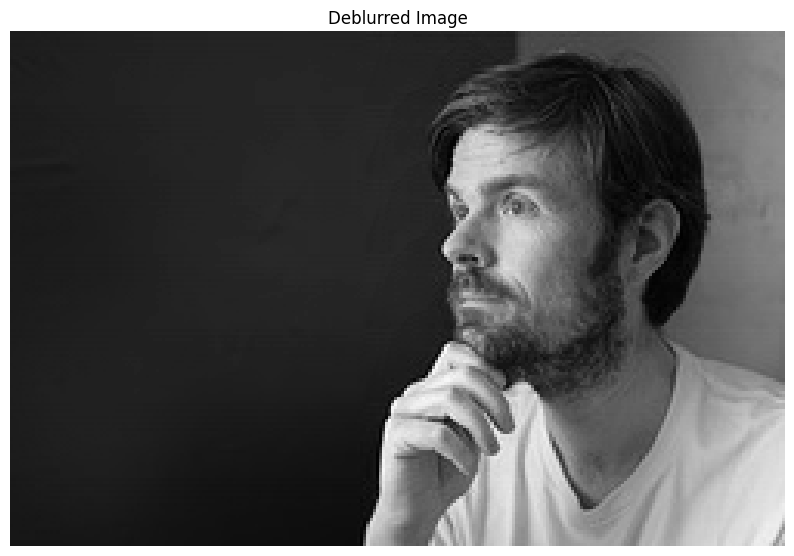

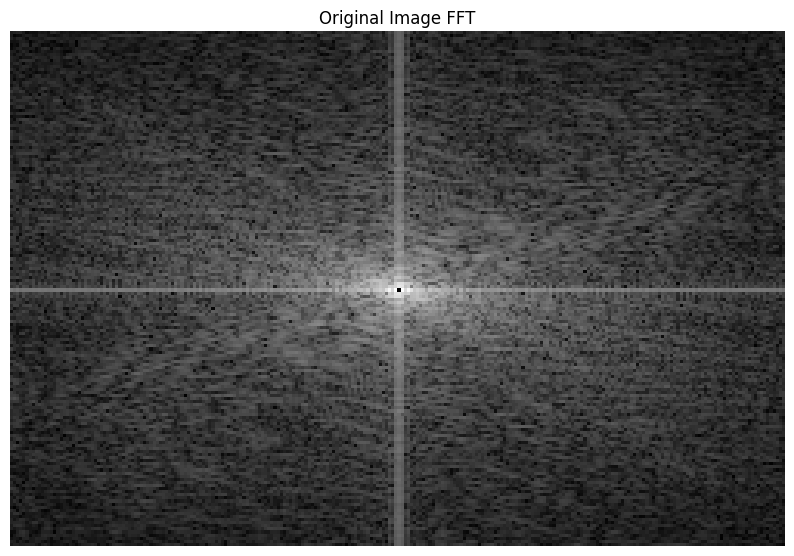

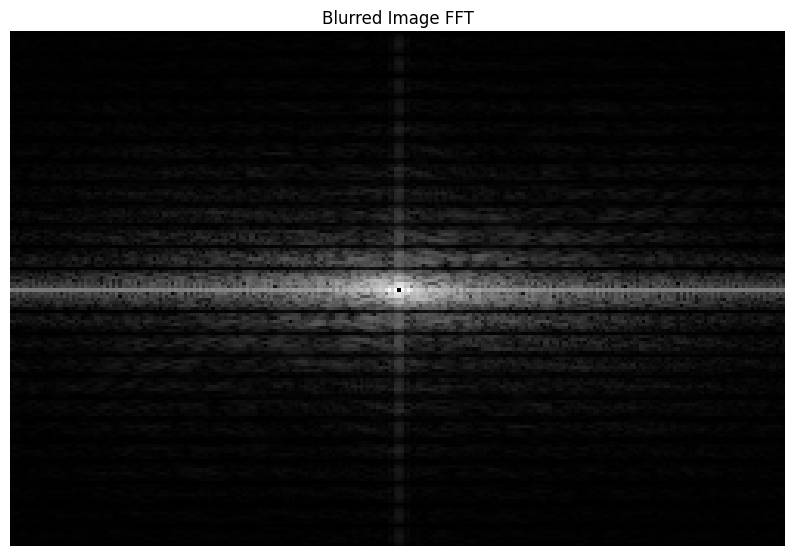

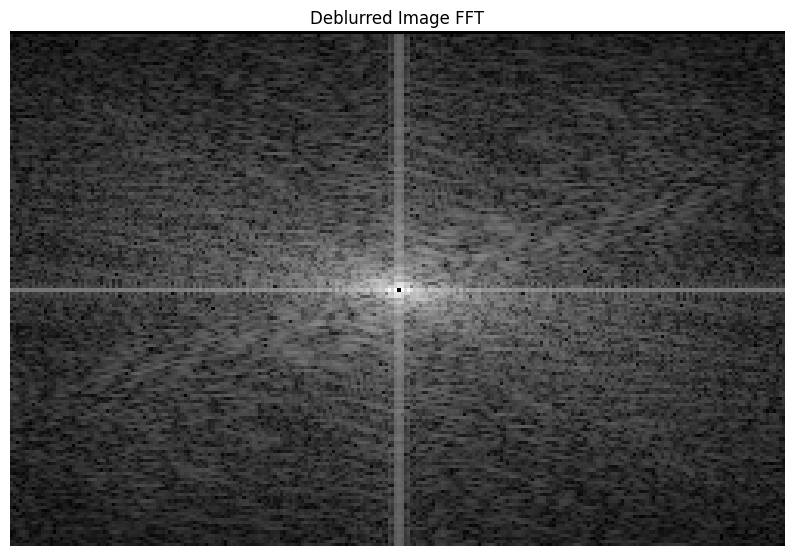

In [ ]:
import torch
import torch.fft as fft
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def load_image(path):
    # Load image and convert to grayscale
    img = Image.open(path).convert('L')
    # Convert to numpy array and then to PyTorch tensor
    img_tensor = torch.from_numpy(np.array(img)).float() / 255.0
    return img_tensor

def display_image(img_tensor, title):
    plt.figure(figsize=(10, 10))
    plt.imshow(img_tensor.squeeze().cpu().numpy(), cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def create_blur_kernel(m, n, s, t, u, v):
    g = torch.cat([torch.ones(s), torch.zeros(m-s-t), torch.ones(t)])
    h = torch.cat([torch.ones(u), torch.zeros(n-u-v), torch.ones(v)])
    g = g / g.abs().sum()
    h = h / h.abs().sum()
    return torch.outer(g, h)

def deblur_image(blurred_img, kernel):
    # Convert to frequency domain
    blurred_fft = fft.fft2(blurred_img)
    kernel_fft = fft.fft2(kernel, s=blurred_img.shape)

    # Pseudo-inverse filter with regularization
    epsilon = 1e-3
    deblurred_fft = blurred_fft / (kernel_fft + epsilon)

    # Convert back to spatial domain
    deblurred = fft.ifft2(deblurred_fft).real
    return deblurred

# Load and preprocess image
img = load_image('/content/6327297101.jpg')
img = img - img.mean()

# Create blur kernel
m, n = img.shape
s, t, u, v = 24, 0, 1, 0
kernel = create_blur_kernel(m, n, s, t, u, v)

# Apply blur
blurred = fft.ifft2(fft.fft2(img) * fft.fft2(kernel, s=img.shape)).real

# Deblur
deblurred = deblur_image(blurred, kernel)

# Display results
display_image(img, 'Original Image')
display_image(blurred, 'Blurred Image')
display_image(deblurred, 'Deblurred Image')

# Display FFT magnitudes
def display_fft(img, title):
    fft_mag = torch.log(1 + torch.abs(fft.fftshift(fft.fft2(img))))
    display_image(fft_mag, title)

display_fft(img, 'Original Image FFT')
display_fft(blurred, 'Blurred Image FFT')
display_fft(deblurred, 'Deblurred Image FFT')

# Save the results
Image.fromarray((deblurred.cpu().numpy() * 255).astype(np.uint8)).save('deblurred_image.jpg')